In [13]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Minimum Variance Portfolio Backtest.

In [14]:
from qamsi.config.trading_config import TradingConfig
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from run import Dataset, initialize

In [15]:
REBAL_FREQ = "ME"
DATASET = Dataset.TOPN_US
TOP_N = 30
ESTIMATION_WINDOW = 365

ESTIMATOR = CovEstimators.PRETRAINED.value(name="irl")

In [16]:
trading_config = TradingConfig(
    total_exposure=1,
    max_exposure=None,
    min_exposure=None,
    trading_lag_days=3,
)

preprocessor, runner = initialize(
    dataset=DATASET,
    with_causal_window=False,
    trading_config=trading_config,
    topn=TOP_N,
    rebal_freq=REBAL_FREQ,
)

Backtest on 2000-12-29 00:00:00 to 2024-07-31 00:00:00
Num Train Iterations: 283
Num OOS Daily Points: 5932


In [17]:
strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Computing Weights: 100%|██████████| 283/283 [00:12<00:00, 22.78it/s]


StrategyStatistics:
* final_nav = 11.943579
* geom_avg_total_r = 0.139339
* geom_avg_xs_r = 0.120042
* std_xs_r = 0.143435
* min_xs_r = -0.079021
* max_xs_r = 0.105264
* skew = 0.139378
* kurtosis = 15.729976
* max_dd = -0.268588
* sharpe = 0.836909
* alpha_buy_hold = 0.049454
* tracking_error_buy_hold = 0.147138
* ir_buy_hold = 0.336109
* factor_loadings = {'low_risk': 0.5237964776484615, 'momentum': -0.08011990523582498, 'quality': 0.1448630744996689, 'size': 0.060334353673276164, 'value': -0.20230889533172744, 'spx': 0.701637528551827}
* alpha_benchmark = 0.051375
* alpha_benchmark_pvalue = 0.010922
* tracking_error_benchmark = 0.084869
* ir_benchmark = 0.605346
* ttest_pval = 0.297855
* levene_pval = 0.000000
* timing_ability_coef = -0.023792
* timing_ability_pval = 0.128424

In [18]:
result.std_xs_r, result.sharpe

(0.14343530558656997, 0.8369091469057763)

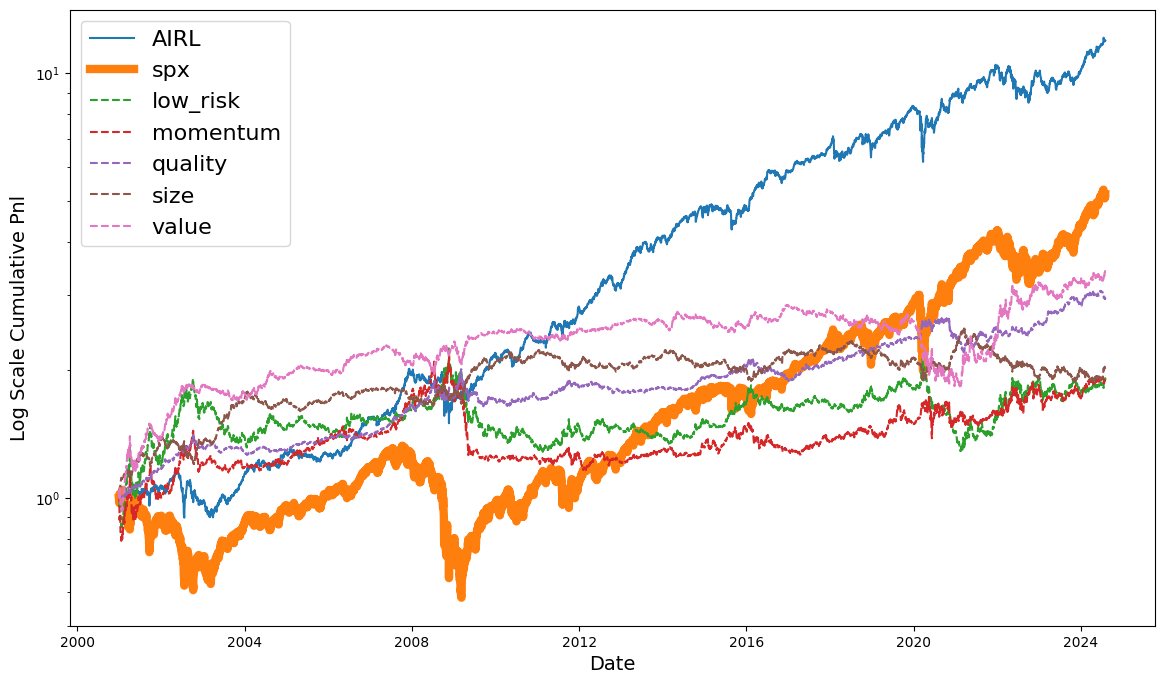

In [19]:
runner.plot_cumulative(
    strategy_name="AIRL",
    include_factors=True,
)

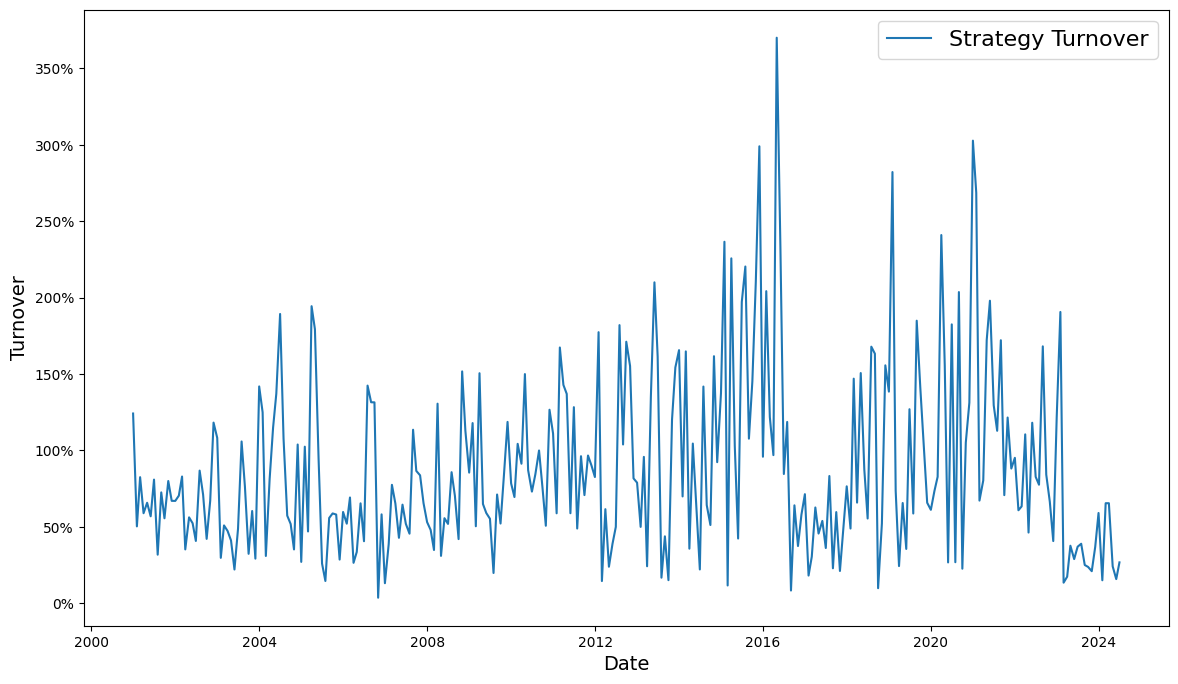

In [20]:
runner.plot_turnover()

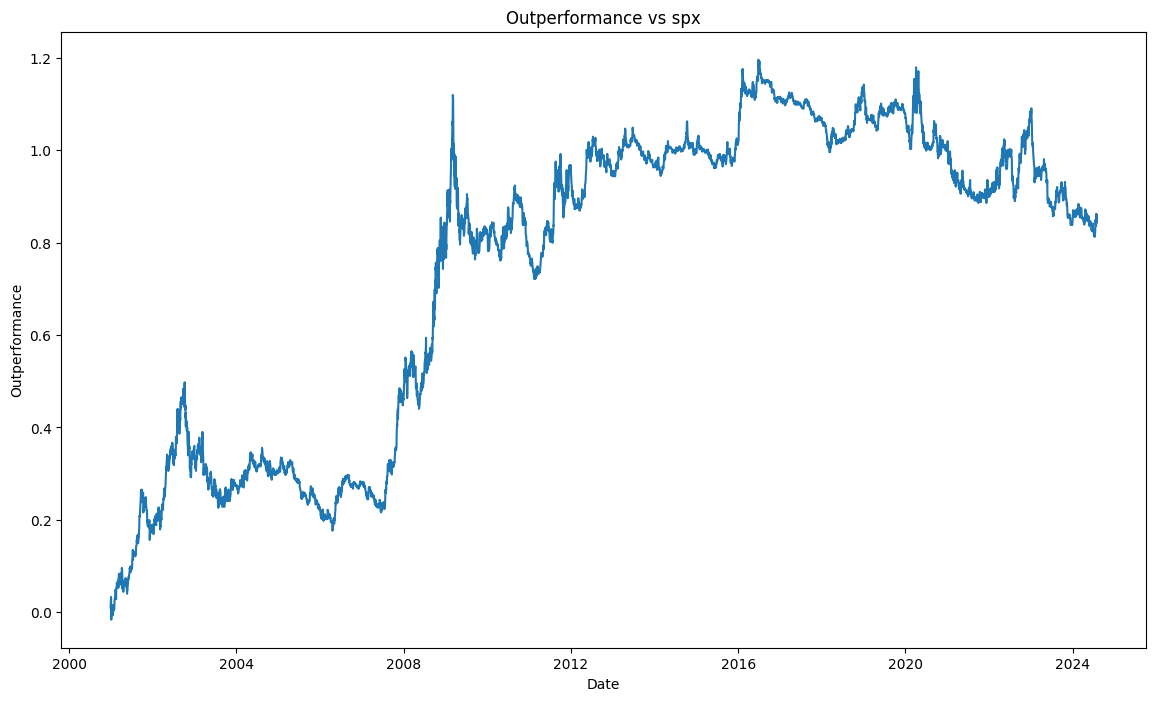

In [21]:
runner.plot_outperformance(mkt_only=True)

In [22]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")

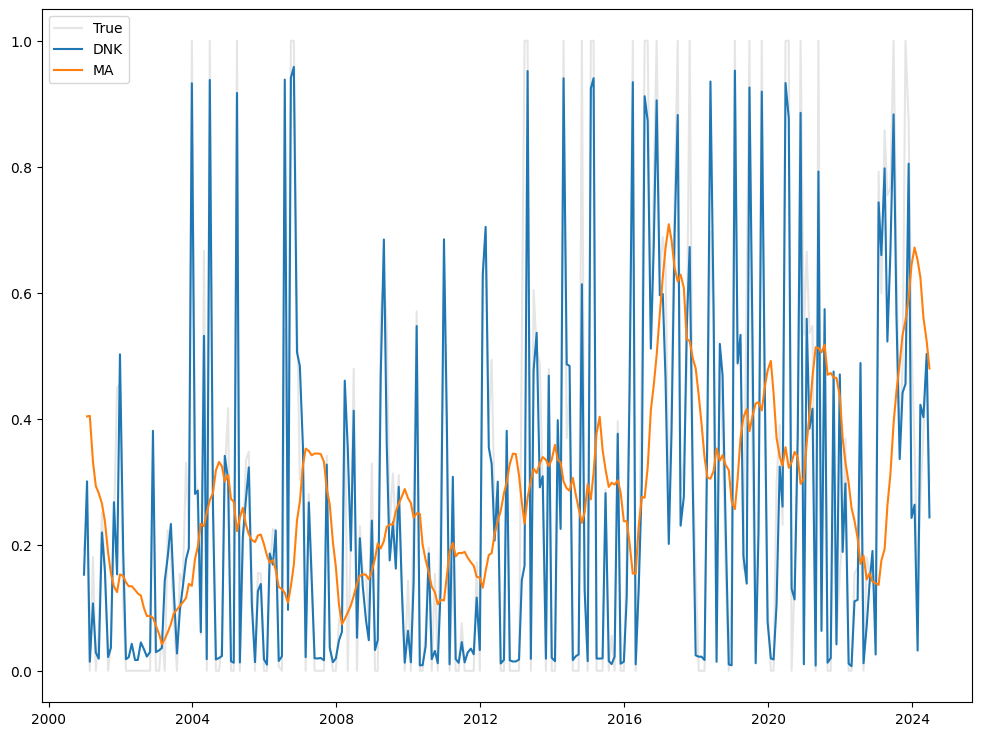

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

pred = ESTIMATOR.predictions

targets = runner.targets.loc[pred.index, "target"]
ma = runner.features.loc[pred.index, "target_rolling_mean"].shift(1)

plt.plot(
    targets.index,
    targets.to_numpy(),
    label="True",
    color="grey",
    alpha=0.2,
)
plt.plot(pred.index, pred.to_numpy(), label="DNK")
plt.plot(ma.index, ma.to_numpy(), label="MA")

plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(targets, pred)

0.06650416090595783